In [1]:
# 07-07-2017
# This file is intended for reading and manipulating all files stored in home/Document/RotatingData/run-8

__author__ = 'Zeyu'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Reading Data
## Reading Raw Data

In [2]:
# folder location and number of data files
folder2 = '/home/ubuntu1/Documents/RotationData/run-11/'
N = 349  # number of data file in the folder2 (index from 0 to 71)

In [3]:
%%time
# read all files in the folder2
df = pd.DataFrame()
for i in range(1,N):
    filename = 'data-file-M-' + str(i)
    d = pd.DataFrame.from_csv(folder2+filename, sep='\t', header=None, index_col=False)
    df= pd.concat([df,d])
na = df.values  # change the dataframe structure to narray

## Extracting Each Trace

explaination of data structure

1 -- Time in normal time format

2 -- Sample number (1..N)

3 -- Measured voltage from Mixer (volts)

4 -- Measured voltage from PLL (volts)

5 -- Position from the encoder (in ticks) [there are 944000 counts per revelation][in run-8 and later the counter is reset at the homing mark, so 944000 is max value]

6 -- Time from the encoder (in micro-seconds) [1MHz clock is on board]

7 —- Ambient temperature in degree C (from run 10)  [This is not contained in run-8]

In [4]:
tn = na[:,0]  # time in normatl time format
sn = na[:,1]  # sampele number
vM = na[:,2]  # measured voltage from Mixer  (volts)
vP = na[:,3]  # measured voltage from PLL  (volts)
pe = na[:,4]  # position from the encoder (ticks)
te = na[:,5]  # time from encoder (ms)

# Visualizing Data
## Ploting Raw data

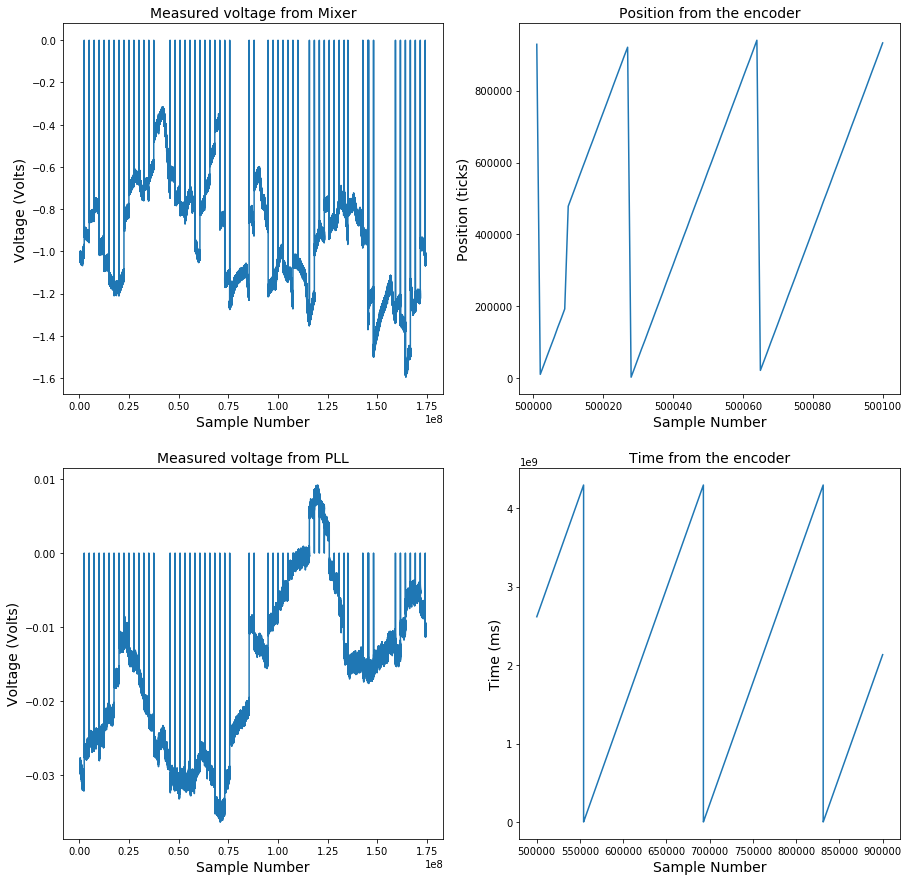

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))  # creating the figure object

# generating each subplot
ax1.plot(sn, vM)
ax1.set_xlabel('Sample Number', fontsize=14)
ax1.set_ylabel('Voltage (Volts)', fontsize=14)
ax1.set_title('Measured voltage from Mixer', fontsize=14)

ax2.plot(sn[0:100], pe[0:100])
ax2.set_xlabel('Sample Number', fontsize=14)
ax2.set_ylabel('Position (ticks)', fontsize=14)
ax2.set_title('Position from the encoder', fontsize=14)

ax3.plot(sn, vP)
ax3.set_xlabel('Sample Number', fontsize=14)
ax3.set_ylabel('Voltage (Volts)', fontsize=14)
ax3.set_title('Measured voltage from PLL', fontsize=14)

ax4.plot(sn[0:int(4e5)], te[0:int(4e5)])
ax4.set_xlabel('Sample Number', fontsize=14)
ax4.set_ylabel('Time (ms)', fontsize=14)
ax4.set_title('Time from the encoder', fontsize=14)

plt.show()

## Manipulating Position and Time

1. change position to angle
    1. Calibration method: position 0 - angle 0; position 944000 - angle 360; Assuming equal interval.
2. aligning time and angle to one line
    1. use python unwrap function

In [ ]:
# change position to angle
ae = pe / 944000 * 360 

# unwrap ae
ae = ae * np.pi / 180  # degree to radius
ae = np.unwrap(ae)

# unwrap te 
nf = 2 * np.pi / te.max()  # normalize factor (radius/ms)
te = te * nf  # normalize it to radius (radius)
te = np.unwrap(te)
te = te / nf  # return te to (ms)

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))  # creating the figure object

# generating each subplot
ax1.plot(sn, vM)
ax1.set_xlabel('Sample Number', fontsize=14)
ax1.set_ylabel('Voltage (Volts)', fontsize=14)
ax1.set_title('Measured voltage from Mixer', fontsize=14)

ax2.plot(sn, ae)
ax2.set_xlabel('Sample Number', fontsize=14)
ax2.set_ylabel('Angle (Radius)', fontsize=14)
ax2.set_title('Angle from the encoder', fontsize=14)

ax3.plot(sn, vP)
ax3.set_xlabel('Sample Number', fontsize=14)
ax3.set_ylabel('Voltage (Volts)', fontsize=14)
ax3.set_title('Measured voltage from PLL', fontsize=14)

ax4.plot(sn, te)
ax4.set_xlabel('Sample Number', fontsize=14)
ax4.set_ylabel('Time (ms)', fontsize=14)
ax4.set_title('Time from the encoder', fontsize=14)

plt.show()

## Fluctuation of Angle and Time
1. calculate the gradiant of angle and time 
2. visulize it

In [ ]:
# calculate the gradient of angle and time
# using np.gradient()
g_ae = np.gradient(ae)
g_te = np.gradient(te)

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))  # creating the figure object

# generating each subplot
ax1.plot(sn, vM)
ax1.set_xlabel('Sample Number', fontsize=14)
ax1.set_ylabel('Voltage (Volts)', fontsize=14)
ax1.set_title('Measured voltage from Mixer', fontsize=14)

ax2.plot(sn, g_ae)
ax2.set_xlabel('Sample Number', fontsize=14)
ax2.set_ylabel('Gradient of Angle (Radius / 1)', fontsize=14)
ax2.set_title('Angle from the encoder', fontsize=14)

ax3.plot(sn, vP)
ax3.set_xlabel('Sample Number', fontsize=14)
ax3.set_ylabel('Voltage (Volts)', fontsize=14)
ax3.set_title('Measured voltage from PLL', fontsize=14)

ax4.plot(sn, g_te)
ax4.set_xlabel('Sample Number', fontsize=14)
ax4.set_ylabel('Gradient of Time (ms / 1)', fontsize=14)
ax4.set_title('Time from the encoder', fontsize=14)

plt.show()

# PSD and CSD of traces
1. Calculate and plot PSD for each trace
2. Calculate and plot CSD for every two traces

## PSD for each trace
calculate PSD using welch function

In [ ]:
# initialization parameters
fs1 = 1612.9/50  # sampling frequency
npp = len(vM)  # length of each section. Same as the length of the original data to reserve information. 

In [ ]:
# calculating PSD using welch function
# for vM
f_vM, S_vM = signal.welch(vM, fs=fs1, nperseg=npp)
S_vM = 10 * np.log10(abs(S_vM).astype(np.float64))  # convention: S = 10 * log10(S)

# for vP
f_vP, S_vP = signal.welch(vP, fs=fs1, nperseg=npp)
S_vP = 10 * np.log10(abs(S_vP).astype(np.float64))

# for g_ae
f_g_ae, S_g_ae = signal.welch(g_ae, fs=fs1, nperseg=npp)
S_g_ae = 10 * np.log10(abs(S_g_ae).astype(np.float64))

# for g_te
f_g_te, S_g_te = signal.welch(g_te, fs=fs1, nperseg=npp)
S_g_te = 10 * np.log10(abs(S_g_te).astype(np.float64))

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))  # creating the figure object

# generating each subplot
ax1.semilogx(f_vM, S_vM)
ax1.set_xlabel('Frequency (Hz)', fontsize=14)
ax1.set_ylabel('PSD', fontsize=14)
ax1.set_title('Measured voltage from Mixer', fontsize=14)

ax2.semilogx(f_g_ae, S_g_ae)
ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('PSD', fontsize=14)
ax2.set_title('Gradient of the angle from the encoder', fontsize=14)

ax3.semilogx(f_vP, S_vP)
ax3.set_xlabel('Frequency (Hz)', fontsize=14)
ax3.set_ylabel('PSD', fontsize=14)
ax3.set_title('Measured voltage from PLL', fontsize=14)

ax4.semilogx(f_g_te, S_g_te)
ax4.set_xlabel('Frequency (Hz)', fontsize=14)
ax4.set_ylabel('PSD', fontsize=14)
ax4.set_title('Gradient of the time from the encoder', fontsize=14)

plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# generating each subplot
ax1.semilogx(f_vM, S_vM)
ax1.set_xlabel('Frequency (Hz)', fontsize=18)
ax1.set_ylabel('Mixer PSD (dBV)', fontsize=18)
ax1.set_xlim([1e-4,1e1])
ax1.set_ylim([-180,10])
ax1.tick_params(labelsize=18)
#ax1.set_title('Measured voltage from Mixer', fontsize=18)

ax2.semilogx(f_vP, S_vP)
ax2.set_xlabel('Frequency (Hz)', fontsize=18)
ax2.set_ylabel('PLL PSD (dBV)', fontsize=18)
ax2.set_xlim([1e-4,1e1])
ax2.set_ylim([-180,10])
ax2.tick_params(labelsize=18)
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
#ax2.set_title('Measured voltage from PLL', fontsize=18)

plt.tight_layout()
f.savefig('./Images/2PSD.eps', fmt='eps')
f.savefig('./Images/2PSD.png', fmt='png')

plt.show()

## Zooming in PSD of measured voltage
we need to zooming in 2 * f_rot because we expect a peak there. Factor 2 is due to the mirror symmetry that the system has.

In [ ]:
f_rot = 1  # rotation frequency
f_rot_z = np.log10(f_rot)

f_start_z = -300  # boundary for frequency of the new plot
f_end_z = 300

f_vM_z = np.log10(f_vM[2:])  # chopped the zero value of f_vM and log10 it
f_vM_z = f_vM_z * 1000000  # change the unit to uHz
Bi = (f_vM_z < f_end_z) * (f_vM_z > f_start_z)  # index of resizing

# zooming in f_vM_lg
f_vM_z = f_vM_z[Bi]
S_vM_z = S_vM[2:][Bi]
S_vP_z = S_vP[2:][Bi]


In [ ]:
f, ax1 = plt.subplots(figsize = (6,4))  # creating the figure object

# generating each subplot
ax1.plot(f_vM_z, S_vM_z, label='Mixer')
ax1.plot(f_vM_z, S_vP_z, label='PLL')
ax1.set_xlim([f_start_z, f_end_z])
l1=ax1.axvline(2*f_rot_z,color='black',ls='--')
l1.set_label('$\log (2\omega_R)$')
ax1.set_xlabel('$\log f$ ($\mu$Hz)', fontsize=18)
ax1.set_ylabel('PSD (dBV)', fontsize=18)
#ax1.set_title('Measured voltage PSD (Zoomed in)', fontsize=18)
ax1.legend(fontsize=16)
ax1.tick_params(labelsize=18)

f.tight_layout()
f.savefig('./Images/ZoomedPSD.eps', fmt='eps')
f.savefig('./Images/ZoomedPSD.png', fmt='png')

plt.show()

## CSD for every two traces

In [ ]:
# compute the CSD between vM and others

# vM and vM
f_vM_vM, C_vM_vM = signal.csd(vM, vM, fs1, nperseg=npp)
S_vM_vM = 10 * np.log10(abs(C_vM_vM).astype(np.float64))

# vM and vP
f_vM_vP, C_vM_vP = signal.csd(vM, vP, fs1, nperseg=npp)
S_vM_vP = 10 * np.log10(abs(C_vM_vP).astype(np.float64))

# vM and ae
f_vM_ae, C_vM_ae = signal.csd(vM, ae, fs1, nperseg=npp)
S_vM_ae = 10 * np.log10(abs(C_vM_ae).astype(np.float64))

# vM and te
f_vM_te, C_vM_te = signal.csd(vM, te, fs1, nperseg=npp)
S_vM_te = 10 * np.log10(abs(C_vM_te).astype(np.float64))


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))  # creating the figure object

# generating each subplot
ax1.semilogx(f_vM_vM, S_vM_vM)
ax1.set_xlabel('Frequency (Hz)', fontsize=14)
ax1.set_ylabel('CSD', fontsize=14)
ax1.set_title('Measured voltage from Mixer', fontsize=14)

ax2.semilogx(f_vM_vP, S_vM_vP)
ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('CSD', fontsize=14)
ax2.set_title('Gradient of the angle from the encoder', fontsize=14)

ax3.semilogx(f_vM_ae, S_vM_ae)
ax3.set_xlabel('Frequency (Hz)', fontsize=14)
ax3.set_ylabel('CSD', fontsize=14)
ax3.set_title('Measured voltage from PLL', fontsize=14)

ax4.semilogx(f_vM_te, S_vM_te)
ax4.set_xlabel('Frequency (Hz)', fontsize=14)
ax4.set_ylabel('CSD', fontsize=14)
ax4.set_title('Gradient of the time from the encoder', fontsize=14)

plt.suptitle('CSD between measured voltage from Mixer and the others', fontsize=20)
plt.show()